### Summary:
In this task I build a predictive model to estimate the percentage of tip given in a taxi ride based on the information available in the dataset. Before the model is built, all the categorical variables are encoded to numeric using a weighted-factor algorithm which normlizes the frequency of each factor with the mean of the target variable.  The model chosen is a Gradient Boosting regressor and is is tunned using 5-fold crossvalidation. Model accuracy metrics are given as the mean squared error. MSE on the test set is < 1%. The most important variables in this model are those related to the final cost of the ride, followed by other extra costs of the rise such as tolls, and trip duration.


In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.model_selection import GridSearchCV
from utils import *

/home/alba/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/alba/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
if os.path.exists('data_nyctaxi_2017_cleaned_2_model.csv'): # Check if the dataset is present on local disk and load it
    data = pd.read_csv('data_nyctaxi_2017_cleaned_2_model.csv')
else:
    print('Run Part-2 first')

In [3]:
data.describe()

,Unnamed: 0,DOLocationID,PULocationID,RatecodeID,VendorID,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,...,trip_distance,Week,Week_day,Month_day,Hour,Trip_duration,Shift_type,Speed_mph,Tip_percentage,With_tip
count,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,...,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1.109528e+06,1109528.0
mean,5.547635e+05,1.618769e+02,1.640701e+02,1.040177e+00,1.541500e+00,3.212213e-01,1.346980e+01,2.999776e-01,4.979819e-01,1.600292e+00,...,3.048356e+00,2.940629e+00,3.990044e+00,1.529404e+01,1.382849e+01,1.682102e+01,1.793457e+00,1.117852e+01,1.611211e+01,1.0
std,3.202933e+05,7.010205e+01,6.599519e+01,2.814929e-01,4.982750e-01,3.719215e-01,1.142373e+01,2.594628e-03,3.180861e-02,1.250949e+00,...,3.811428e+00,1.318138e+00,1.877335e+00,8.865403e+00,6.276174e+00,4.950240e+01,7.100369e-01,6.229666e+00,4.383357e+00,0.0
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-4.200000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.457719e-03,1.0
25%,2.773818e+05,1.130000e+02,1.140000e+02,1.000000e+00,1.000000e+00,0.000000e+00,7.000000e+00,3.000000e-01,5.000000e-01,1.000000e+00,...,1.010000e+00,2.000000e+00,2.000000e+00,8.000000e+00,9.000000e+00,7.133333e+00,1.000000e+00,7.234450e+00,1.522881e+01,1.0
50%,5.547635e+05,1.620000e+02,1.620000e+02,1.000000e+00,2.000000e+00,0.000000e+00,1.000000e+01,3.000000e-01,5.000000e-01,1.000000e+00,...,1.700000e+00,3.000000e+00,4.000000e+00,1.500000e+01,1.500000e+01,1.181667e+01,2.000000e+00,9.859873e+00,1.666431e+01,1.0
75%,8.321452e+05,2.340000e+02,2.330000e+02,1.000000e+00,2.000000e+00,5.000000e-01,1.500000e+01,3.000000e-01,5.000000e-01,2.000000e+00,...,3.200000e+00,4.000000e+00,6.000000e+00,2.300000e+01,1.900000e+01,1.926667e+01,2.000000e+00,1.344059e+01,1.666667e+01,1.0
max,1.109527e+06,2.650000e+02,2.650000e+02,6.000000e+00,2.000000e+00,1.000000e+00,4.105000e+02,3.000000e-01,9.300000e-01,9.000000e+00,...,5.985000e+02,5.000000e+00,7.000000e+00,3.100000e+01,2.300000e+01,1.439633e+03,3.000000e+00,2.400000e+02,9.983880e+01,1.0


In [4]:
target = 'Tip_percentage'


var = ['DOLocationID_RATIO', 'PULocationID_RATIO', 'RatecodeID_RATIO', 'VendorID_RATIO', 'extra', 'fare_amount'
       , 'improvement_surcharge', 'month_RATIO', 'mta_tax', 'passenger_count', 'store_and_fwd_flag_RATIO'
       , 'tolls_amount', 'total_amount', 'Dropoff_dt_RATIO',  'Pickup_dt_RATIO', 'trip_distance', 'Week_RATIO'
       , 'Week_day_RATIO', 'Month_day_RATIO', 'Hour_RATIO', 'Trip_duration', 'Shift_type_RATIO', 'Speed_mph']

var_cat= ['RatecodeID', 'VendorID', 'month', 'Month_day','store_and_fwd_flag', 'Dropoff_dt',  'Pickup_dt', 'Week',
 'Week_day', 'Month_day', 'Hour', 'Shift_type','DOLocationID', 'PULocationID']

In [5]:
data["DOLocationID"] = data["DOLocationID"].astype('category')
data["PULocationID"] = data["PULocationID"].astype('category')
data["RatecodeID"] = data["RatecodeID"].astype('category')
data["VendorID"] = data["VendorID"].astype('category')
data["payment_type"] = data["payment_type"].astype('category')
data["Week"] = data["Week"].astype('category')
data["Week_day"] = data["Week_day"].astype('category')
data["Month_day"] = data["Month_day"].astype('category')
data["month"] = data["month"].astype('category')
data["Hour"] = data["Hour"].astype('category')
data["Dropoff_dt"]=data["Dropoff_dt"].astype('category')
data["Pickup_dt"]=data["Pickup_dt"].astype('category')
data["Shift_type"]=data["Shift_type"].astype('category')

### Splitting data into training and test

In [6]:
mydata={}
mydata['train'], mydata['test']= mysplit(data, 0.6, 12345)

In [7]:
pd.set_option('display.max_columns', 500)
mydata['train'].head(2)

,Unnamed: 0,DOLocationID,PULocationID,RatecodeID,VendorID,extra,fare_amount,improvement_surcharge,month,mta_tax,passenger_count,payment_type,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,Dropoff_dt,Pickup_dt,trip_distance,Week,Week_day,Month_day,Hour,Trip_duration,Shift_type,Speed_mph,Tip_percentage,With_tip,rand
1,1,238,249,1,2,0.5,19.5,0.3,Nov,0.5,1,1,N,3.55,0.0,24.35,2017-11-26 20:50:41,2017-11-26 20:28:02,5.30,4.0,7,26,20,22.65,2.0,14.039735,14.579055,1,0.316376
2,2,238,142,1,2,0.5,5.5,0.3,Nov,0.5,1,1,N,1.70,0.0,8.50,2017-11-29 20:05:08,2017-11-29 19:59:50,0.93,5.0,3,29,19,5.30,2.0,10.528302,20.000000,1,0.183919


### Encoding categorical variables to numeric 

In [8]:
mydata['train'] = encode_vars_ratio(mydata, mydata['train'], mydata['train'], var_cat, target, True, 100)

In [9]:
mydata['test'] = encode_vars_ratio(mydata, mydata['test'], mydata['test'], var_cat, target, True, 100)

In [54]:
pd.set_option('display.max_columns', 500)
mydata['train'].head(2)

,Unnamed: 0,DOLocationID,PULocationID,RatecodeID,VendorID,extra,fare_amount,improvement_surcharge,month,mta_tax,passenger_count,payment_type,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,Dropoff_dt,Pickup_dt,trip_distance,Week,Week_day,Month_day,Hour,Trip_duration,Shift_type,Speed_mph,Tip_percentage,With_tip,rand,Tip_percentage_AUX,RatecodeID_RATIO,VendorID_RATIO,month_RATIO,Month_day_RATIO,store_and_fwd_flag_RATIO,Dropoff_dt_RATIO,Pickup_dt_RATIO,Week_RATIO,Week_day_RATIO,Month_day_RATIO_AUX,Hour_RATIO,Shift_type_RATIO,DOLocationID_RATIO,PULocationID_RATIO
294691,491011,170,211,1,2,1.0,14.0,0.3,March,0.5,1,1,N,3.95,0.0,19.75,2017-03-24 17:43:33,2017-03-24 17:23:56,2.37,4.0,5,24,17,19.616667,2.0,7.248938,20.000000,1,0.318788,20.000000,16.121914,16.240243,16.116945,16.078260,16.110197,16.109908,16.109908,16.111109,16.054379,16.078260,16.043070,16.063614,16.216456,16.042719
600574,1001648,186,142,1,2,1.0,11.5,0.3,March,0.5,1,1,N,2.66,0.0,15.96,2017-03-09 16:31:49,2017-03-09 16:17:55,2.31,2.0,4,9,16,13.900000,2.0,9.971223,16.666667,1,0.443135,16.666667,16.121914,16.240243,16.116945,16.157412,16.110197,16.109908,16.109908,16.137232,16.143520,16.157412,16.102672,16.063614,16.887518,16.193381


### Building the Model:
* Type of model: regression or classification?
The goal of the task is to predict the tip given to the driver in a ride. Thus, I choose a regression model instead of a classification one. The latter would answer the question of whether the client would tip or not.
* I tune the model hyperparameters using the gridsearch algorithm on the training set.
* The chosen accuracy metric is the mean squared error. MSE on the training set is 0.90 %

In [24]:
# Here I optimize the parameters for the predictive algorithm

parameters = {'n_estimators': [100,150], 'max_depth':[4,6,8], 'min_samples_split': [20,30,40],
          'learning_rate': [0.06], 'loss': ['ls']}

clf = GridSearchCV(ensemble.GradientBoostingRegressor(), parameters)
clf.fit(mydata['train'][var], mydata['train'][target])

print("Best parameters combination")
print(clf.best_params_)
print("F1 scores on each combination:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters combination
{'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 150}
F1 scores on each combination:
0.544 (+/-0.026) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 20, 'n_estimators': 100}
0.658 (+/-0.017) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 20, 'n_estimators': 150}
0.545 (+/-0.027) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 30, 'n_estimators': 100}
0.657 (+/-0.021) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 30, 'n_estimators': 150}
0.551 (+/-0.025) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 40, 'n_estimators': 100}
0.661 (+/-0.011) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 40, 'n_estimators': 150}
0.750 (+/-0.014) for {'learning_rate': 0.06, 'loss': 'ls', 'max_depth': 6, 'min_samples_split': 20, 'n_estimators':

In [26]:
# Save model
with open('rf_classif.pkl','wb') as fid:
    pickle.dump(clf.best_estimator_,fid)
    fid.close()

In [43]:
# Best estimator
print(clf.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.06, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


### Crossvalidation and variable importance

In [30]:
d = clf.best_estimator_.feature_importances_
aux = sum(d)
dd = []
for index, k in enumerate(d):
    d[index] = d[index] / (aux + 0.0)
    dd.append((var[index],d[index]))

dd = sorted(dd, key=lambda x:-x[1])
dd

[('total_amount', 0.5128327728992546),
 ('fare_amount', 0.3522244665824546),
 ('extra', 0.06991939543527063),
 ('tolls_amount', 0.036480844341213514),
 ('Trip_duration', 0.006748360611156047),
 ('trip_distance', 0.005920314842003525),
 ('PULocationID_RATIO', 0.0030020138277131294),
 ('DOLocationID_RATIO', 0.0029756427111114724),
 ('Speed_mph', 0.0023737730338965804),
 ('Hour_RATIO', 0.0017353375762488104),
 ('Month_day_RATIO', 0.0013069054328716937),
 ('Shift_type_RATIO', 0.0011179750096855),
 ('RatecodeID_RATIO', 0.0007839053320972845),
 ('mta_tax', 0.00066402815917176),
 ('VendorID_RATIO', 0.0006591613925443771),
 ('Week_day_RATIO', 0.0005136342730434033),
 ('passenger_count', 0.00047490242333743344),
 ('month_RATIO', 0.00013284983625271396),
 ('Week_RATIO', 9.196230669034263e-05),
 ('store_and_fwd_flag_RATIO', 3.296316896033867e-05),
 ('improvement_surcharge', 8.79080502244123e-06),
 ('Dropoff_dt_RATIO', 0.0),
 ('Pickup_dt_RATIO', 0.0)]


Model report:
Accuracy: 0.9025264608491875
CV Score - Mean : -1.511006 | Std : 0.09660979 | Min : -1.638512 | Max : -1.378403


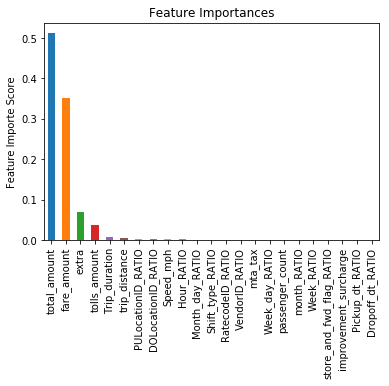

In [39]:
# cross-validate the best model with optimized number of estimators: mean square error and variable importance.


modelfit(clf.best_estimator_,mydata['train'],var,target,'mean_squared_error')

### Accuracy over test dataset


Model report:
Accuracy: 0.9582997211893277
CV Score - Mean : -1.177777 | Std : 0.02996949 | Min : -1.222793 | Max : -1.139931


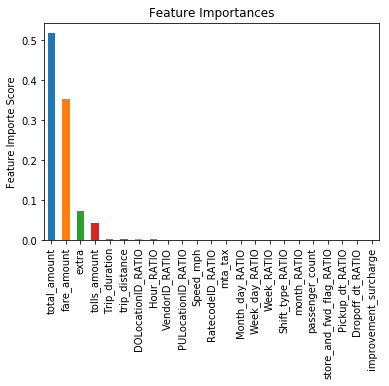

In [44]:
# cross validate the best model with optimized number of estimators

modelfit(clf.best_estimator_,mydata['test'],var,target,'mean_squared_error')

###
* The average predicted tip is 16.11%
* The mean absolute error is 0.9% over the trainng set and 0.95% on the test set.

### Last Remarks
* The most important variables in this model are those related to the final cost of the ride, followed by other extra costs of the rise such as tolls, and trip duration.
* It seems that the pickup/dropoff location id is also important. 
* As a follow-up work, I would dig on these type of variables. Where in the map are this locations? Is there any geospatial correlation on the tip given in the rides? It would be interesting, for example, to add variables related to the socio-demographics of these locations. Also, we could add information on the traffic conditions when the ride takes place. 
* If we wish to turn this model into an web service, I would use a framework such as Flask.This application will respond to external requests.